In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Dataset.csv",delimiter=',',encoding='latin-1')
df = df[['Category','Message']]
df = df[pd.notnull(df['Message'])]
df.rename(columns = {'Message':'Message'}, inplace = True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df.index = range(5572)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

87265

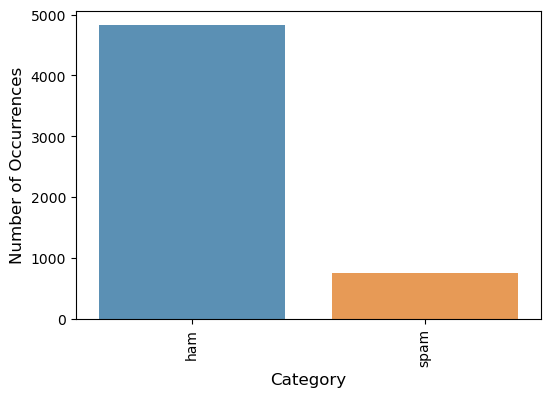

In [6]:
cnt_pro = df['Category'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=cnt_pro.index, y = cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [7]:
def print_message(index):
    example = df[df.index == index][['Message', 'Category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

URGENT! You have won a 1 week FREE membership in our Â£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
Message: spam


In [8]:
print_message(0)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Message: ham


In [9]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

C:\Users\HP\AppData\Local\Temp\ipykernel_2516\2959445239.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [10]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.3 , random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Category]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

C:\Users\HP\AppData\Local\Temp\ipykernel_2516\2959445239.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


Found 5572 unique tokens.


In [11]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5572, 50)


In [12]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['quite', 'late', 'lar', '...', 'ard', '12', 'anyway', 'i', 'wun', 'b', 'drivin', '...'], tags=['ham']),
       TaggedDocument(words=['on', 'a', 'tuesday', 'night', 'r', 'u', '4', 'real'], tags=['ham']),
       TaggedDocument(words=['go', 'chase', 'after', 'her', 'and', 'run', 'her', 'over', 'while', 'she', "'s", 'crossing', 'the', 'street'], tags=['ham']),
       ...,
       TaggedDocument(words=['prabha', '..', 'i', "'m", 'soryda', '..', 'realy', '..', 'frm', 'heart', 'i', "'m", 'sory'], tags=['ham']),
       TaggedDocument(words=['nt', 'joking', 'seriously', 'i', 'told'], tags=['ham']),
       TaggedDocument(words=['did', 'he', 'just', 'say', 'somebody', 'is', 'named', 'tampa'], tags=['ham'])],
      dtype=object)

In [13]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


100%|█████████████████████████████████████████████████████████████████████████| 3900/3900 [00:00<00:00, 3791790.82it/s]


In [14]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████████████████████████████████████████████████████████████████████████████████| 3900/3900 [00:00<?, ?it/s]


CPU times: total: 6.12 s
Wall time: 8.17 s


In [15]:
print(d2v_model)

Doc2Vec<dm/m,d100,n5,w8,s0.001>


In [16]:
# len(d2v_model.wv.vocab)
vocab_len = len(d2v_model.wv)
vocab_len

7763

In [17]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((vocab_len + 1, 20))

# for i, vec in enumerate(d2v_model.dv.index_to_key[n]):
for i, vec in enumerate(d2v_model.dv.vectors):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

In [18]:
d2v_model.wv.most_similar(positive=['urgent'], topn=10)


[('0906346330.', 0.6619471311569214),
 ('09066350750', 0.5881916284561157),
 ('08712402902', 0.5769001245498657),
 ('complimentary', 0.5685564279556274),
 ('ultimatum', 0.5562721490859985),
 ('landline', 0.547625720500946),
 ('abta', 0.5390720963478088),
 ('08712402578', 0.5353204607963562),
 ('del', 0.5317204594612122),
 ('09066612661', 0.530586302280426)]

In [19]:
d2v_model.wv.most_similar(positive=['cherish'], topn=10)


[('okors', 0.6687023043632507),
 ('mojibiola', 0.6684948205947876),
 ('wish', 0.590773344039917),
 ('enjoyed', 0.5663537383079529),
 ('thank', 0.5523818731307983),
 ('ultimatum', 0.5456810593605042),
 ('dawns', 0.5438106656074524),
 ('abi', 0.5423650741577148),
 ('burial', 0.5422309041023254),
 ('semester', 0.528960108757019)]

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# Initiate the model
model = Sequential()

# Add the Embedding layer without weights
model.add(Embedding(vocab_len + 1, 20, input_shape=(X.shape[1],), trainable=True))

# Set the embedding weights
model.layers[0].set_weights([embedding_matrix])

# Learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))

model.add(LSTM(50, return_sequences=False))
model.add(Dense(2, activation="sigmoid"))

# Output model skeleton
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])

# Assuming you have your training data (X) and labels (y) ready
# model.fit(X, y, epochs=10, batch_size=32)

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 20)              │         155,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          14,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,582 (662.43 KB)

 Trainable params: 169,582 (662.43 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
Y = pd.get_dummies(df['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3900, 50) (3900, 2)
(1672, 50) (1672, 2)


In [22]:
batch_size = 64
history=model.fit(X_train, Y_train, epochs =5, batch_size=batch_size, verbose = 2)

Epoch 1/5
61/61 - 3s - 53ms/step - acc: 0.8828 - loss: 0.3539
Epoch 2/5
61/61 - 1s - 17ms/step - acc: 0.9703 - loss: 0.1295
Epoch 3/5
61/61 - 1s - 17ms/step - acc: 0.9864 - loss: 0.0634
Epoch 4/5
61/61 - 1s - 17ms/step - acc: 0.9887 - loss: 0.0442
Epoch 5/5
61/61 - 1s - 16ms/step - acc: 0.9933 - loss: 0.0280


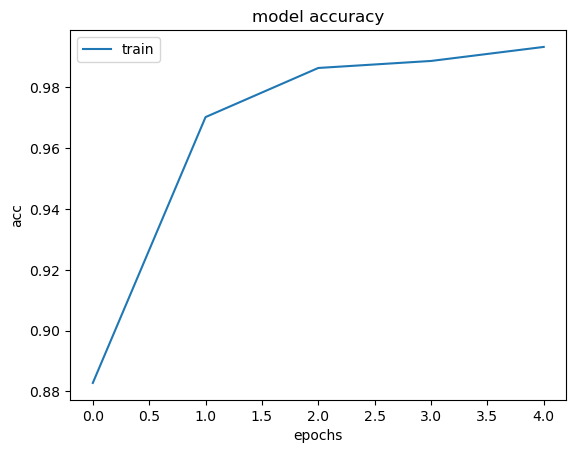

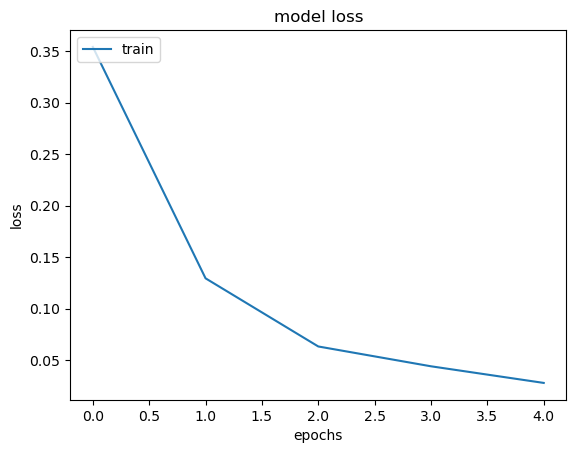

<Figure size 640x480 with 0 Axes>

In [23]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [24]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

122/122 - 1s - 7ms/step - acc: 0.9967 - loss: 0.0188
53/53 - 0s - 5ms/step - acc: 0.9874 - loss: 0.0553
Train: 0.997, Test: 0.9874


In [25]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
print(yhat_classes)

# predict_x=model.predict(X_test) 
# classes_x=np.argmax(predict_x,axis=1)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[0.99692786 0.00346593]
 [0.98255175 0.01799106]
 [0.9974183  0.00292913]
 ...
 [0.9980547  0.00226463]
 [0.0151749  0.98752534]
 [0.9973882  0.00295335]]
[0 0 0 ... 0 1 0]


In [26]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[1440,    8],
       [  13,  211]], dtype=int64)

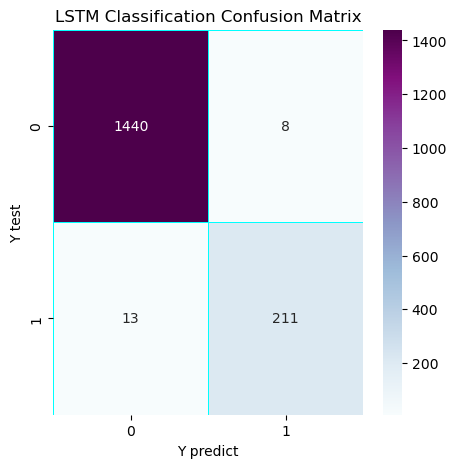

In [28]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

In [29]:
validation_size = 200

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9842 - loss: 0.0662
score: 0.06
acc: 0.99


In [30]:
message = ['Congratulations! you have won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.02413129 0.9794801 ]] spam


In [31]:
message = ['thanks for accepting my request to connect']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['ham','spam']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.9956921  0.00442252]] ham


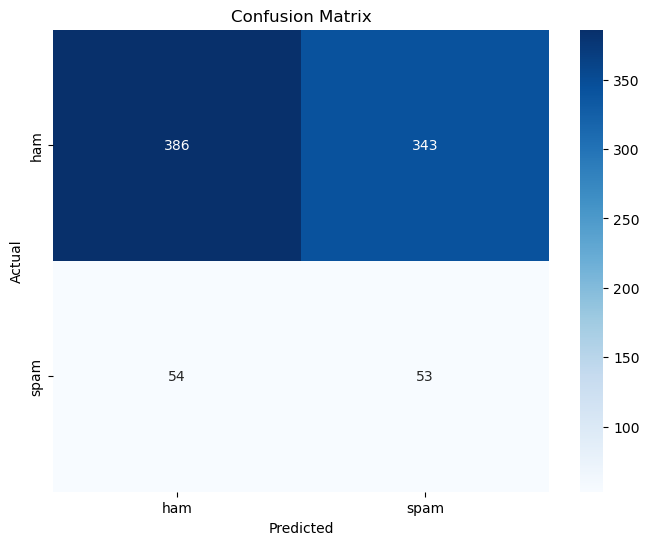

In [55]:
from sklearn.metrics import confusion_matrix

# Ensure both arrays have the same length
min_length = min(len(rounded_labels), len(yhat_classes))
rounded_labels = rounded_labels[:min_length]
yhat_classes = yhat_classes[:min_length]

# Compute the confusion matrix
conf_matrix = confusion_matrix(rounded_labels, yhat_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
